# Bregman Divergence for Few-shot learning in crop pest classification - Adult insect

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Packages

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
import multiprocessing as mp

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


### Define image size

In [ ]:
nH = 96 # image.shape = [nH,nH,3]

## Import data

In [ ]:
# # Meta-training
path_train = '/content/drive/MyDrive/Few_shot_Learning/datasets/IP102_dataset_remodeled/adult/train_classes'
path_test = '/content/drive/MyDrive/Few_shot_Learning/datasets/IP102_dataset_remodeled/adult/test_classes'

### Read data

In [ ]:
def read_classes(class_path, class_name,nH): 
    datax = []
    datay = []
    images = os.listdir(class_path)
    for img in images:
        image = cv2.resize(cv2.imread(class_path + '/' + img),(nH,nH))

        # Rotate images to create new classes
        rotated_90 = ndimage.rotate(image, 90)
        rotated_180 = ndimage.rotate(image, 180)
        rotated_270 = ndimage.rotate(image, 270)
        datax.extend((image, rotated_90, rotated_180, rotated_270))
        datay.extend((
            class_name + '_0',
            class_name + '_90',
            class_name + '_180',
            class_name + '_270'
        ))
        
    return np.array(datax), np.array(datay)

In [ ]:
def read_images(base_directory, nH):
    """
    Reads all the classes from the base_directory
    Uses multithreading to decrease the reading time
    """
    datax = None
    datay = None
    
    pool = mp.Pool(mp.cpu_count())
    results = [pool.apply(read_classes, args=(base_directory + '/' + directory + '/', directory, nH,
                          )) for directory in os.listdir(base_directory)]
    pool.close()

    # results = [read_classes(base_directory + '/' + directory + '/', directory) for directory in os.listdir(base_directory)]

    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [ ]:
%%time 
trainx, trainy = read_images(path_train,nH)

In [ ]:
%%time 
testx, testy = read_images(path_test, nH)

In [ ]:
trainx.shape, trainy.shape, testx.shape, testy.shape

## Create samples

In [ ]:
def extract_sample(n_way, n_support, n_query, datax, datay):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  K = np.random.choice(np.unique(datay), n_way, replace=False)
  for cls in K:
    datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [ ]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  # Need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  # Make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

As an example, let's pick a sample

*   n_way = 5
*   n_support = 4
*   n_query = 3

torch.Size([5, 7, 3, 96, 96])

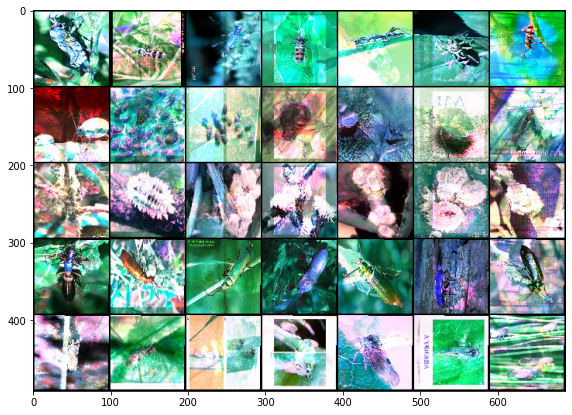

In [ ]:
sample_example = extract_sample(5, 4, 3, trainx, trainy)
# display_sample(sample_example['images'])
display_sample(F.normalize(sample_example['images'], p=10, dim=0))
sample_example['images'].shape # [N, k+q, chanels, width, height]

## Build model

### Model

In [ ]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.MaxPool2d(3)
        )
    
  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )
    
  return ProtoNet(encoder)

### Summary model

In [ ]:
from torchsummary import summary

def load_protonet_conv_copy(**kwargs): 
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.MaxPool2d(3)
        )
    
  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )
    
  return encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = load_protonet_conv_copy(
    x_dim=(3,nH,nH),
    hid_dim=64,
    z_dim=128,
    ).to(device)

summary(model, (3, nH, nH))  
# print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
       BatchNorm2d-2           [-1, 64, 96, 96]             128
              ReLU-3           [-1, 64, 96, 96]               0
           Dropout-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,928
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
           Dropout-9           [-1, 64, 32, 32]               0
        MaxPool2d-10           [-1, 64, 10, 10]               0
           Conv2d-11           [-1, 64, 10, 10]          36,928
      BatchNorm2d-12           [-1, 64, 10, 10]             128
             ReLU-13           [-1, 64, 10, 10]               0
          Dropout-14           [-1, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Encoder

In [ ]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample, divergence):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
        divergence (string): Bregman divergence chosen for training
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
   
    # Target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()
   
    # Encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
    z = self.encoder.forward(x)
    z_dim = z.size(-1)

    # Z_PROTO
    z_proto = z[:n_way*n_support]

    # Z_QUERY
    z_query = z[n_way*n_support:]

    # COMPUTE DISTANCES
    # --- Euclidean ---
    if divergence == 1:
      dists = euclidean_dist(z_query, z_proto.view(n_way, n_support, z_dim).mean(1))
    
    # --- Mahalanobis ---
    elif divergence == 2:
      dists = mahalanobis_dist(z_query, z_proto.view(n_way, n_support, z_dim))

    # --- Kullback–Leibler – KL ---
    elif divergence == 3:
      dists = KL_dist(z_query, z_proto.view(n_way, n_support, z_dim).mean(1))

    # --- Itakura–Saito - IS ---
    elif divergence == 4:
      dists = IS_dist(z_query, z_proto.view(n_way, n_support, z_dim).mean(1))

    # Compute probabilities, loss, y_hat, and accuracy
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

## Bregman divergence
https://en.wikipedia.org/wiki/Bregman_divergence#cite_note-4

### Euclidean

In [ ]:
def euclidean_dist(x, y):
  """
  Computes euclidean distance between x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the euclidean distance to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

### Mahalanobis

In [ ]:
# Estimate a covariance matrix
def cov(tensor, rowvar=True, bias=False):
    tensor = tensor if rowvar else tensor.transpose(-1, -2)
    tensor = tensor - tensor.mean(dim=-1, keepdim=True)
    factor = 1 / (tensor.shape[-1] - int(not bool(bias)))
    
    return torch.matmul(factor * tensor, tensor.transpose(-1, -2).conj())

In [ ]:
def mahalanobis_dist(x, y):
    """
    Computes Mahalanobis distance between each vector in x and distribution y
    Args:
        x (torch.Tensor): shape (n, d). n usually n_way*n_query
        y (torch.Tensor): shape (N, m, d). N usually n_way, m usually n_support
    Returns:
        torch.Tensor: shape(n, 1). For each query, the mahalanobis distance to each distribution in y
    """
    # Compute covariance matrix
    covariances = cov(y)
    
    # Compute inverse of covariance matrix
    cov_Inv = torch.inverse(covariances)

    x = x.unsqueeze(0)
    
    n = x.size(1)
    m = y.size(1)
    d = x.size(2)
    N = y.size(0)
    assert d == y.size(2)

    x = x.unsqueeze(2).expand(N, n, m, d)
    y = y.unsqueeze(1).expand(N, n, m, d)

    # Compute Mahalanobis distances
    mahal = (x-y).sum(3) @ cov_Inv @ torch.transpose((x-y).sum(3), -2, -1)

    return torch.transpose(torch.diagonal(mahal, 0, 1, 2), 0, 1) / 1000

### Kullback–Leibler - KL

In [ ]:
def KL_dist(x, y):
    """ 
    KL (x || y)
    Computes Kullback–Leibler divergence from x to y
    Args:
        x (torch.Tensor): shape (n, d). n usually n_way*n_query
        y (torch.Tensor): shape (m, d). m usually n_way
    Returns:
        torch.Tensor: shape(n, 1). For each query, the KL divergence to each centroid
    """
    x = x / torch.transpose((x.sum(1).expand(x.shape[1], x.shape[0])), 0, 1)
    y = y / torch.transpose((y.sum(1).expand(y.shape[1], y.shape[0])), 0, 1)

    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    # Since log (0) is negative infinity, let's add a small value to avoid it
    eps = 0.01

    return (x * torch.log((x+eps) / (y+eps))).sum(2) * 100

### Itakura–Saito - IS

In [ ]:
def IS_dist(x, y):
    """ 
    IS (x || y)
    Computes Itakura–Saito divergence from x to y
    Args:
        x (torch.Tensor): shape (n, d). n usually n_way*n_query
        y (torch.Tensor): shape (m, d). m usually n_way
    Returns:
        torch.Tensor: shape(n, 1). For each query, the IS divergence to each centroid
    """
    x = x / torch.transpose((x.sum(1).expand(x.shape[1], x.shape[0])), 0, 1)
    y = y / torch.transpose((y.sum(1).expand(y.shape[1], y.shape[0])), 0, 1)

    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    
    # Since log (0) is negative infinity, let's add a small value to avoid it
    eps = 0.01

    return (((x+eps) / (y+eps)) - torch.log((x+eps) / (y+eps)) - 1).sum(2)

## Train

In [ ]:
from tqdm import tqdm_notebook
from tqdm import tnrange

In [ ]:
# Plot the training history
def plot_history(history):
  # x = range(1, len(history["hist_acc"]) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history["hist_epoch"], history["hist_acc"], 'b', label='Training acc')
  plt.title('Training accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history["hist_epoch"], history["hist_loss"], 'r', label='Training loss')
  plt.title('Training loss')
  plt.legend() 

In [ ]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size, divergence):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
      divergence (string): Bregman divergence chosen for training
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample, divergence)

      # loss.requires_grad = True # Adicionei esta linha
      
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))

# Keep the training history
    history["hist_loss"].append(epoch_loss)
    history["hist_acc"].append(epoch_acc)
    history["hist_epoch"].append(epoch+1)   # */ 

    epoch += 1
    scheduler.step()

In [ ]:
%%time
# Initialize the training history
history = {"hist_loss": [], "hist_acc": [], "hist_epoch": []}

model = load_protonet_conv(
    x_dim=(3,nH,nH),
    hid_dim=64,
    z_dim=256,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

# For Mahalanobis, n_support must >= 2
n_way = 3
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 10
epoch_size = 2000

# --- Choose Bregman Divergence ---
# Euclidean:         1
# Mahalanobis:       2
# Kullback–Leibler:  3
# Itakura-Saito:     4

divergence = 1

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size, divergence)

In [ ]:
plot_history(history)

## Test

In [ ]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode, divergence):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
      divergence (string): Bregman divergence chosen for training
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample, divergence)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [ ]:
n_way = 3

test_x = testx
test_y = testy

test_episode = 1000

test(model, test_x, test_y, n_way, n_support, n_query, test_episode, divergence)